# Neuron Activation Projection Analysis

This notebook analyzes the relationship between ground truth neuron activations and four projection directions:
1. The prediction head direction
2. The neuron input weight direction
3. The neuron output weight direction
4. The final residual stream

Given an output directory from a previous run, the notebook will load model outputs and run a correlation analysis between these different directions.

## 1. Setup and Imports

In [1]:
# Imports
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns
from pathlib import Path
from scipy import stats
from transformer_lens import HookedTransformer
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

/opt/homebrew/anaconda3/envs/neuron_selection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Utility functions for loading data
def load_head(model_path):
    """Load the saved prediction head and its configuration"""
    config_path = os.path.join(model_path, "config.json")
    head_path = os.path.join(model_path, "head.pt")
    
    with open(config_path, "r") as f:
        config = json.load(f)
    
    head_weights = torch.load(head_path, map_location="cpu")
    
    return head_weights, config

def load_dataset(dataset_path):
    """Load dataset with input texts and ground truth activations"""
    return pd.read_csv(dataset_path)

def extract_model_info_from_path(output_dir):
    """Parse the output directory path to identify target layer and neuron"""
    # Look for neuron information in directory name 
    dir_name = os.path.basename(output_dir)
    # Try to extract from patterns like neuron_l8_n481
    import re
    matches = re.search(r'neuron_l(\d+)_n(\d+)', dir_name)
    
    if matches:
        layer = int(matches.group(1))
        neuron = int(matches.group(2))
        return layer, neuron
    
    # If not found in directory name, look in subdirectories
    for root, dirs, files in os.walk(output_dir):
        for d in dirs:
            matches = re.search(r'neuron_l(\d+)_n(\d+)', d)
            if matches:
                layer = int(matches.group(1))
                neuron = int(matches.group(2))
                return layer, neuron
    
    # If still not found, look for a datasets directory
    datasets_dir = os.path.join(output_dir, "datasets")
    if os.path.exists(datasets_dir):
        for file in os.listdir(datasets_dir):
            if file.endswith(".csv"):
                matches = re.search(r'neuron_l(\d+)_n(\d+)', file)
                if matches:
                    layer = int(matches.group(1))
                    neuron = int(matches.group(2))
                    return layer, neuron

    # If still not found, check introspection summary
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            if "introspection_summary" in file and file.endswith(".json"):
                with open(os.path.join(root, file), "r") as f:
                    try:
                        summary = json.load(f)
                        if "target_layer" in summary and "target_neuron" in summary:
                            return summary["target_layer"], summary["target_neuron"]
                    except json.JSONDecodeError:
                        continue
    
    # If we can't determine, raise an error
    raise ValueError(f"Could not determine layer and neuron from directory: {output_dir}")

In [3]:
# MLP weight access functions from linear_weights_analysis notebook
def get_neuron_in_weights(model, layer, neuron=None):
    """Get weights from residual stream into MLP layer"""
    # Try different model architectures
    try:
        # TransformerLens standard format
        if hasattr(model.blocks[layer].mlp, "W_in"):
            mlp_in = model.blocks[layer].mlp.W_in
        # GPT-2 style
        elif hasattr(model.blocks[layer].mlp, "c_fc"):
            mlp_in = model.blocks[layer].mlp.c_fc
        # Fallback for other architectures
        else:
            # Try to find any weight matrix in the MLP module
            for name, module in model.blocks[layer].mlp.named_modules():
                if isinstance(module, torch.nn.Linear) and module.weight.shape[0] > model.cfg.d_model:
                    mlp_in = module.weight
                    break
            else:
                raise ValueError("Couldn't find MLP input weights")
                
        if neuron is not None:
            return mlp_in[:, neuron]  # Column corresponding to this neuron
        return mlp_in
    except Exception as e:
        logging.error(f"Error accessing MLP input weights: {e}")
        logging.error("Model structure:")
        for name, param in model.named_parameters():
            if f"blocks.{layer}" in name and "mlp" in name and "weight" in name:
                logging.error(f"  {name}: {param.shape}")
        raise

def get_neuron_out_weights(model, layer, neuron=None):
    """Get weights from MLP neuron to output"""
    # Try different model architectures
    try:
        # TransformerLens standard format
        if hasattr(model.blocks[layer].mlp, "W_out"):
            mlp_out = model.blocks[layer].mlp.W_out
        # GPT-2 style
        elif hasattr(model.blocks[layer].mlp, "c_proj"):
            mlp_out = model.blocks[layer].mlp.c_proj
        # Fallback for other architectures
        else:
            # Try to find any weight matrix in the MLP module with appropriate shape
            for name, module in model.blocks[layer].mlp.named_modules():
                if isinstance(module, torch.nn.Linear) and module.weight.shape[1] > model.cfg.d_model:
                    mlp_out = module.weight
                    break
            else:
                raise ValueError("Couldn't find MLP output weights")
                
        if neuron is not None:
            return mlp_out[neuron] # Row corresponding to this neuron 
        return mlp_out
    except Exception as e:
        logging.error(f"Error accessing MLP output weights: {e}")
        logging.error("Model structure:")
        for name, param in model.named_parameters():
            if f"blocks.{layer}" in name and "mlp" in name and "weight" in name:
                logging.error(f"  {name}: {param.shape}")
        raise

def extract_linear_weights(head_weights, config, base_model=None):
    """Extract the linear prediction tensor from the head"""
    head_type = config["head_type"]
    
    if head_type == "regression":
        # For regression head, extract the final linear layer weights
        if "hidden.weight" in head_weights:
            # Has hidden layer - need to compose the transformation
            hidden_w = head_weights["hidden.weight"]
            hidden_b = head_weights["hidden.bias"]
            output_w = head_weights["output.weight"]
            output_b = head_weights["output.bias"]
            
            # Note: This is an approximation, as we're ignoring the non-linearity
            # We'll use only the linear component for direct comparison
            linear_weights = output_w.squeeze()
            logging.info("Using output layer weights from regression head with hidden layer")
        else:
            # Direct linear projection
            linear_weights = head_weights["output.weight"].squeeze()
            logging.info("Using output layer weights from regression head without hidden layer")
    
    elif head_type == "classification":
        # For classification head, combine weights based on bin edges
        output_weights = head_weights["output.weight"]
        bin_edges = config.get("bin_edges")
        
        if bin_edges:
            # Calculate bin centers
            bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
            
            # Weight each class weight by its bin center to get a linear approximation
            combined_weights = torch.zeros_like(output_weights[0])
            for i, center in enumerate(bin_centers):
                if i < output_weights.shape[0]:
                    combined_weights += output_weights[i] * center
            
            linear_weights = combined_weights
            logging.info(f"Using weighted combination of classification weights with {len(bin_centers)} bin centers")
        else:
            # If no bin edges, use the first class weight as an approximation
            linear_weights = output_weights[0]
            logging.warning("Using first class weight as approximation (no bin edges found)")
    
    elif head_type == "token":
        # For token head, weights come from the base model's embedding
        if base_model is None:
            raise ValueError("Base model is required for token head analysis")
            
        # Get digit tokens (0-9) from the head config or use defaults
        digit_tokens = config.get("head_config", {}).get("digit_tokens", list(range(48, 58)))  # ASCII 0-9
        
        if not digit_tokens:
            # Fallback to ASCII digits if no tokens found
            digit_tokens = list(range(48, 58))
            
        # Get embedding vectors for digit tokens
        digit_embeddings = base_model.embed.weight[digit_tokens]
        
        # Weight each embedding by its value (0-9)
        combined_weights = torch.zeros_like(digit_embeddings[0])
        for i, embedding in enumerate(digit_embeddings):
            combined_weights += embedding * (i / 9.0)  # Normalize to 0-1 range
        
        linear_weights = combined_weights
        logging.info(f"Using weighted combination of {len(digit_tokens)} token embeddings")
    
    else:
        raise ValueError(f"Unknown head type: {head_type}")
    
    return linear_weights.cpu()

## 2. Data Loading

In [4]:
# Set the output directory to analyze
output_dir = "/Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_n481--mse29.02-20250422_1259"

device = 'mps'

# Extract target layer and neuron from directory name
target_layer, target_neuron = extract_model_info_from_path(output_dir)
print(f"Target Layer: {target_layer}, Target Neuron: {target_neuron}")

Target Layer: 8, Target Neuron: 481


In [5]:
# Find dataset file
print(f'Working dir: {os.getcwd()}')
print(f'Output dir: {output_dir}')
datasets_dir = os.path.join(output_dir, "datasets")

dataset_file = None
print(f'Datasets dir: {datasets_dir}')
if os.path.exists(datasets_dir):
    for file in os.listdir(datasets_dir):
        print(f'File: {file}')
        if file.endswith(".csv") and f"neuron_l{target_layer}_n{target_neuron}" in file:
            dataset_file = os.path.join(datasets_dir, file)
            break
else:
    print(f'Nothing in datasets dir: {datasets_dir}')

# Load the dataset
if dataset_file and os.path.exists(dataset_file):
    print(f"Loading dataset from: {dataset_file}")
    dataset = load_dataset(dataset_file)
    print(f"Dataset shape: {dataset.shape}")
    print(f"Dataset columns: {dataset.columns.tolist()}")
else:
    raise FileNotFoundError(f"Dataset file not found for neuron l{target_layer}_n{target_neuron}")

Working dir: /Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_n481--mse29.02-20250422_1259
Output dir: /Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_n481--mse29.02-20250422_1259
Datasets dir: /Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_n481--mse29.02-20250422_1259/datasets
File: neuron_l8_n481_20250422_120142_distribution.png
File: neuron_l8_n481_20250422_120142.csv
Loading dataset from: /Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_

In [6]:
# Find model directory and load head
models_dir = os.path.join(output_dir, "models")
if not os.path.exists(models_dir):
    # Look for models in parent directory structure
    for root, dirs, files in os.walk(output_dir):
        if "models" in dirs:
            models_dir = os.path.join(root, "models")
            break

model_dir = None
if os.path.exists(models_dir):
    for d in os.listdir(models_dir):
        if f"neuron_l{target_layer}_n{target_neuron}" in d:
            # Look for best_model subdirectory
            best_model_dir = os.path.join(models_dir, d, "best_model")
            if os.path.exists(best_model_dir):
                model_dir = best_model_dir
                break
            # Otherwise use the directory itself
            model_dir = os.path.join(models_dir, d)
            break

if model_dir is None or not os.path.exists(model_dir):
    # Look elsewhere
    for root, dirs, files in os.walk(output_dir):
        if "best_model" in dirs:
            model_dir = os.path.join(root, "best_model")
            break
        for d in dirs:
            if f"neuron_l{target_layer}_n{target_neuron}" in d and os.path.exists(os.path.join(root, d, "config.json")):
                model_dir = os.path.join(root, d)
                break
        if model_dir:
            break

# Load the trained model head
if model_dir and os.path.exists(model_dir):
    print(f"Loading model from: {model_dir}")
    head_weights, config = load_head(model_dir)
    print(f"Head type: {config['head_type']}")
else:
    raise FileNotFoundError(f"Model directory not found for neuron l{target_layer}_n{target_neuron}")

Loading model from: /Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_n481--mse29.02-20250422_1259/models/neuron_l8_n481_20250422_120142/best_model
Head type: regression


In [7]:
# Load the base transformer model
base_model_name = config["base_model_name"]
base_model = HookedTransformer.from_pretrained(base_model_name)

print(f"Base model: {base_model_name}")
print(f"Model configuration:")
print(f"  Hidden dimension: {base_model.cfg.d_model}")
print(f"  MLP dimension: {base_model.cfg.d_mlp}")
print(f"  Number of layers: {base_model.cfg.n_layers}")

Loaded pretrained model gpt2 into HookedTransformer
Base model: gpt2
Model configuration:
  Hidden dimension: 768
  MLP dimension: 3072
  Number of layers: 12


## 3. Extract Weight Directions

In [8]:
# Extract the weight vectors for our analysis
# 1. Linear prediction weights from the head
head_weights_vector = extract_linear_weights(head_weights, config, base_model).to(device)
print(f"Head weights shape: {head_weights_vector.shape}")

# 2. MLP input weights for the target neuron
input_weights_vector = get_neuron_in_weights(base_model, target_layer, target_neuron)
print(f"Input weights shape: {input_weights_vector.shape}")

# 3. MLP output weights for the target neuron
output_weights_vector = get_neuron_out_weights(base_model, target_layer, target_neuron)
print(f"Output weights shape: {output_weights_vector.shape}")

# Create normalized versions for direction-only analysis
head_weights_norm = F.normalize(head_weights_vector, dim=0)
input_weights_norm = F.normalize(input_weights_vector, dim=0)
output_weights_norm = F.normalize(output_weights_vector, dim=0)

2025-04-30 10:24:12,522 - INFO - Using output layer weights from regression head without hidden layer


Head weights shape: torch.Size([768])
Input weights shape: torch.Size([768])
Output weights shape: torch.Size([768])


In [9]:
# Calculate cosine similarities between the weight vectors
sim_head_input = F.cosine_similarity(head_weights_vector, input_weights_vector, dim=0)
sim_head_output = F.cosine_similarity(head_weights_vector, output_weights_vector, dim=0)
sim_input_output = F.cosine_similarity(input_weights_vector, output_weights_vector, dim=0)

print(f"Cosine similarity between head weights and input weights: {sim_head_input:.4f}")
print(f"Cosine similarity between head weights and output weights: {sim_head_output:.4f}")
print(f"Cosine similarity between input weights and output weights: {sim_input_output:.4f}")

Cosine similarity between head weights and input weights: 0.0453
Cosine similarity between head weights and output weights: -0.0309
Cosine similarity between input weights and output weights: -0.3627


## 4. Process Input Texts

In [10]:
# Set up hooks for collecting activations at different points
pre_mlp_acts = []
post_mlp_acts = []
final_acts = []
ground_truth_acts = []

def pre_mlp_hook(acts, hook):
    # Get the last token only
    last_token_acts = acts[:, -1, :]
    pre_mlp_acts.append(last_token_acts.detach().cpu())
    return acts

def post_mlp_hook(acts, hook):
    # Get the last token only
    last_token_acts = acts[:, -1, :]
    post_mlp_acts.append(last_token_acts.detach().cpu())
    return acts

def final_layer_hook(acts, hook):
    # Get the last token only
    last_token_acts = acts[:, -1, :]
    final_acts.append(last_token_acts.detach().cpu())
    return acts

In [11]:
# Process the input texts to collect activations
# We'll sample a subset if the dataset is large
max_samples = 500  # Adjust based on dataset size
if len(dataset) > max_samples:
    dataset_sample = dataset.sample(max_samples, random_state=42)
else:
    dataset_sample = dataset

print(f"Processing {len(dataset_sample)} input texts")

# Register hooks
hooks = [
    (f"blocks.{target_layer}.hook_resid_pre", pre_mlp_hook),
    (f"blocks.{target_layer}.hook_resid_post", post_mlp_hook),
    (f"blocks.{base_model.cfg.n_layers-1}.hook_resid_post", final_layer_hook)
]

# Set up results storage
projection_results = []

# Process inputs
with torch.no_grad():
    with base_model.hooks(hooks):
        for i, row in dataset_sample.iterrows():
            if i % 100 == 0:
                print(f"Processing sample {i}/{len(dataset_sample)}")
                
            # Get the input text and tokenize
            input_text = row["text"]
            tokens = base_model.tokenizer(input_text, return_tensors="pt")
            
            # Run through the model
            base_model(tokens["input_ids"])
            
            # Get ground truth activation
            ground_truth = row["activation"]
            ground_truth_acts.append(ground_truth)


Processing 500 input texts
Processing sample 0/500
Processing sample 100/500
Processing sample 200/500
Processing sample 300/500
Processing sample 400/500


In [12]:
# Calculate projections onto the weight vectors
head_projections = []
input_projections = []
output_projections = []
neuron_dir_projections = []  # For the "neuron direction" in the final layer

# Calculate head projections on final layer
for acts in final_acts:
    # Project final activations onto head weights
    proj = torch.matmul(acts.to(device), head_weights_vector)
    head_projections.append(proj.item())

# Calculate input projections on pre-MLP activations
for acts in pre_mlp_acts:
    # Project pre-MLP activations onto input weights
    proj = torch.matmul(acts.to(device), input_weights_vector)
    input_projections.append(proj.item())
    
# Calculate output projections on post-MLP activations
for acts in post_mlp_acts:
    # Project post-MLP activations onto output weights
    proj = torch.matmul(acts.to(device), output_weights_vector)
    output_projections.append(proj.item())
    
# Calculate "neuron direction" projections on final layer
# This is projecting the final layer activations onto the normalized output weights vector
for acts in final_acts:
    # Project final activations onto normalized output weights
    proj = torch.matmul(acts.to(device), output_weights_norm)
    neuron_dir_projections.append(proj.item())

In [13]:
# Compile results into a dataframe
results_df = pd.DataFrame({
    "ground_truth": ground_truth_acts,
    "head_projection": head_projections,
    "input_projection": input_projections,
    "output_projection": output_projections,
    "neuron_dir_projection": neuron_dir_projections
})

# Display summary statistics
print(results_df.describe())

       ground_truth  head_projection  input_projection  output_projection  \
count    500.000000       500.000000        500.000000         500.000000   
mean      16.893528       -14.833864         -2.609248          20.448161   
std        3.650163         2.291655          0.909670           4.552541   
min        5.104774       -21.389843         -4.859735           7.818525   
25%       14.530351       -16.142880         -3.370757          17.437999   
50%       17.088169       -14.759159         -2.665803          20.475107   
75%       19.334919       -13.060919         -1.861465          23.854095   
max       25.068182        -8.274500         -0.215138          31.230892   

       neuron_dir_projection  
count             500.000000  
mean                2.620960  
std                 4.235108  
min                -6.069749  
25%                -0.227149  
50%                 2.579230  
75%                 5.660736  
max                13.753880  


## 5. Correlation Analysis

In [14]:
# Calculate correlations between ground truth and projections
corr_head = results_df["ground_truth"].corr(results_df["head_projection"])
corr_input = results_df["ground_truth"].corr(results_df["input_projection"])
corr_output = results_df["ground_truth"].corr(results_df["output_projection"])
corr_neuron_dir = results_df["ground_truth"].corr(results_df["neuron_dir_projection"])

print(f"Correlation between ground truth and head projection: {corr_head:.4f}")
print(f"Correlation between ground truth and input projection: {corr_input:.4f}")
print(f"Correlation between ground truth and output projection: {corr_output:.4f}")
print(f"Correlation between ground truth and neuron direction projection: {corr_neuron_dir:.4f}")

Correlation between ground truth and head projection: 0.1736
Correlation between ground truth and input projection: -0.4894
Correlation between ground truth and output projection: -0.0147
Correlation between ground truth and neuron direction projection: -0.3710


In [15]:
# Calculate full correlation matrix
correlation_matrix = results_df.corr()
print("Full correlation matrix:")
print(correlation_matrix)

Full correlation matrix:
                       ground_truth  head_projection  input_projection  \
ground_truth               1.000000         0.173560         -0.489360   
head_projection            0.173560         1.000000         -0.155637   
input_projection          -0.489360        -0.155637          1.000000   
output_projection         -0.014675         0.229069         -0.028928   
neuron_dir_projection     -0.371034        -0.641404          0.256071   

                       output_projection  neuron_dir_projection  
ground_truth                   -0.014675              -0.371034  
head_projection                 0.229069              -0.641404  
input_projection               -0.028928               0.256071  
output_projection               1.000000               0.168786  
neuron_dir_projection           0.168786               1.000000  


In [16]:
# Calculate coefficient of determination (R²)
r2_head = corr_head ** 2
r2_input = corr_input ** 2
r2_output = corr_output ** 2
r2_neuron_dir = corr_neuron_dir ** 2

print(f"R² for head projection: {r2_head:.4f}")
print(f"R² for input projection: {r2_input:.4f}")
print(f"R² for output projection: {r2_output:.4f}")
print(f"R² for neuron direction projection: {r2_neuron_dir:.4f}")

R² for head projection: 0.0301
R² for input projection: 0.2395
R² for output projection: 0.0002
R² for neuron direction projection: 0.1377


In [17]:
# Calculate statistical significance
n = len(results_df)

def pearson_p_value(r, n):
    # Calculate t statistic
    t = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
    # Calculate p-value
    p = 2 * (1 - stats.t.cdf(abs(t), n - 2))
    return p

p_head = pearson_p_value(corr_head, n)
p_input = pearson_p_value(corr_input, n)
p_output = pearson_p_value(corr_output, n)
p_neuron_dir = pearson_p_value(corr_neuron_dir, n)

print(f"p-value for head projection correlation: {p_head:.8f}")
print(f"p-value for input projection correlation: {p_input:.8f}")
print(f"p-value for output projection correlation: {p_output:.8f}")
print(f"p-value for neuron direction projection correlation: {p_neuron_dir:.8f}")

p-value for head projection correlation: 0.00009586
p-value for input projection correlation: 0.00000000
p-value for output projection correlation: 0.74341090
p-value for neuron direction projection correlation: 0.00000000


## 6. Visualization

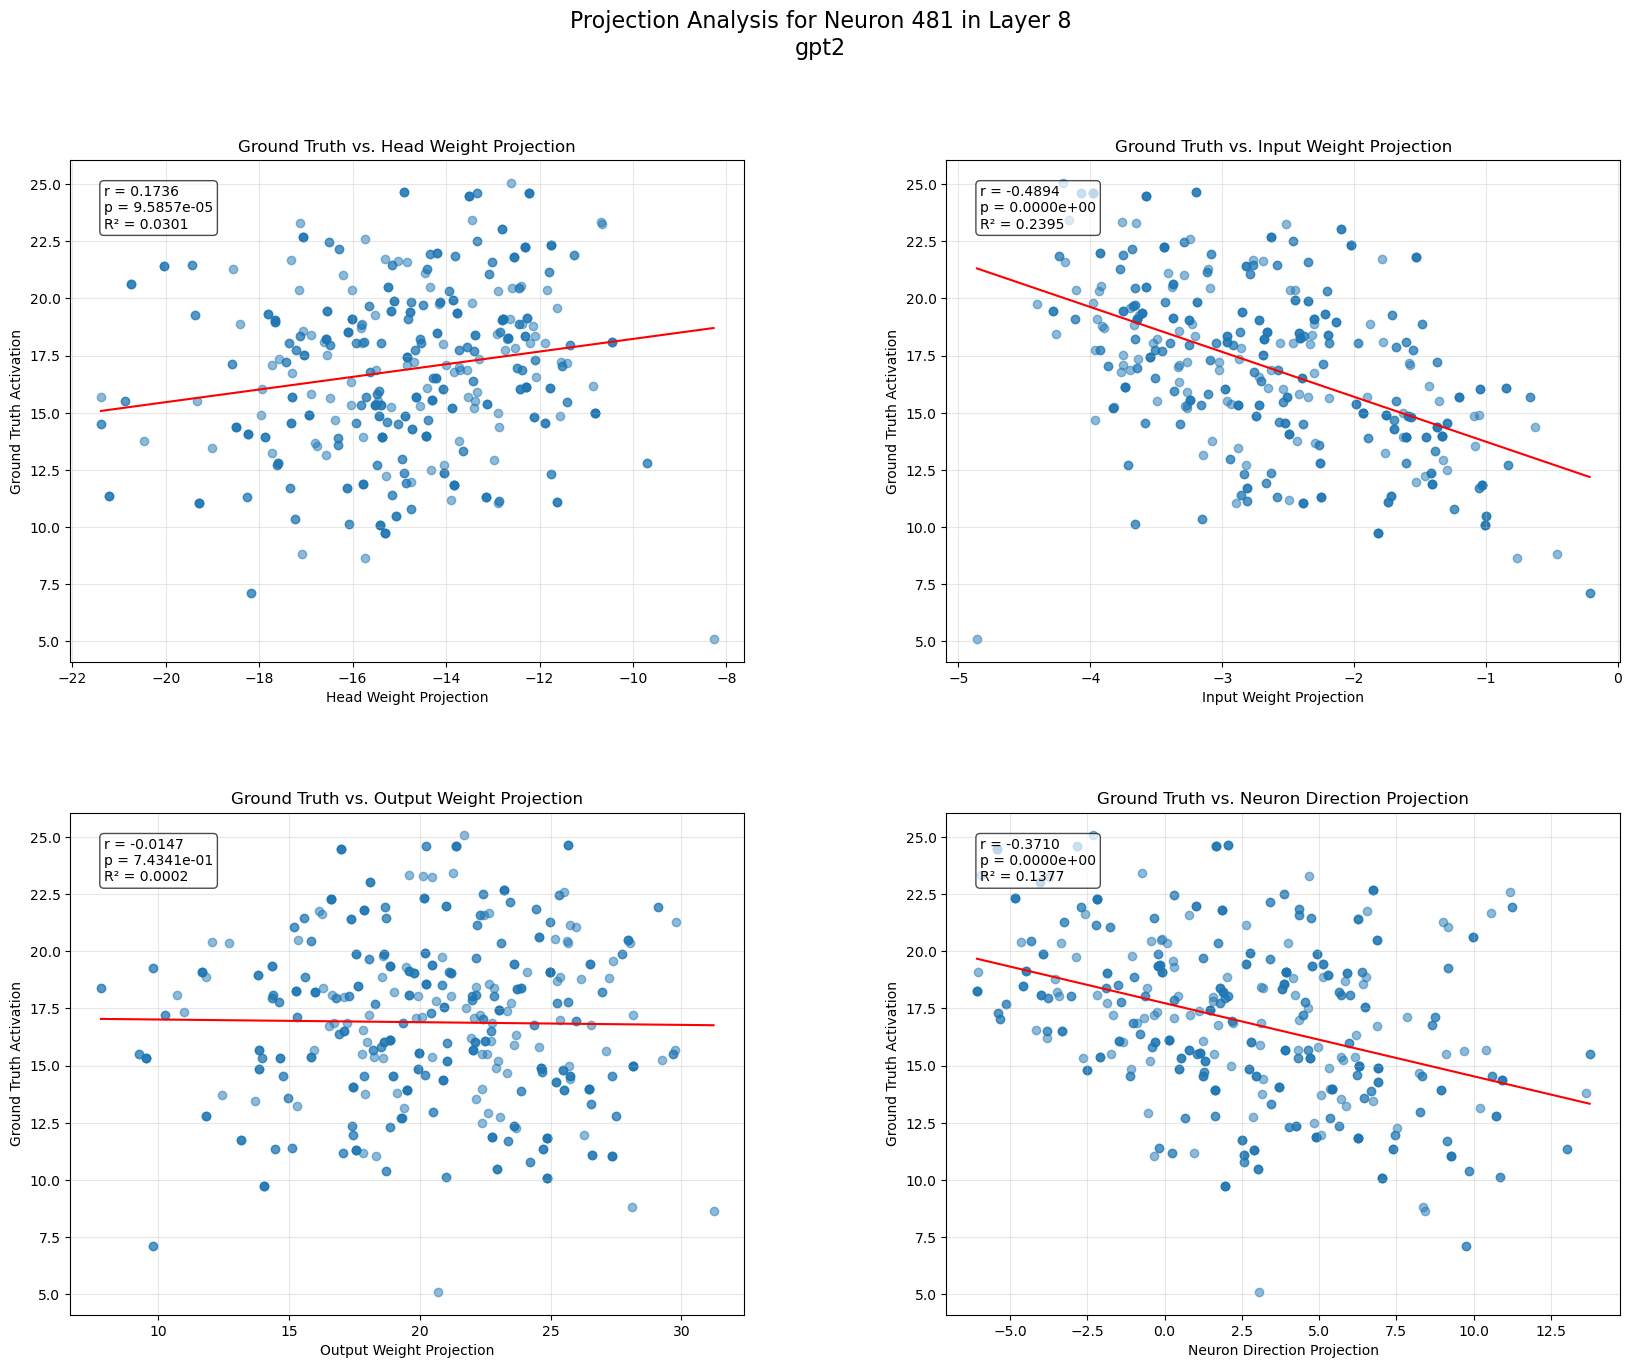

In [18]:
# Set up plots with regression lines and marginal histograms
import matplotlib.gridspec as gridspec
from scipy import stats

# Create a 4-panel plot
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.3)

# Helper function to create scatter plot with regression line and histograms
def create_scatter_with_marginals(x, y, xlabel, ylabel, ax_idx, corr, p_val, r2):
    # Main scatter plot
    ax_main = fig.add_subplot(gs[ax_idx])
    ax_main.scatter(x, y, alpha=0.5)
    
    # Add regression line
    slope, intercept, _, _, _ = stats.linregress(x, y)
    x_line = np.linspace(min(x), max(x), 100)
    y_line = slope * x_line + intercept
    ax_main.plot(x_line, y_line, 'r-')
    
    # Add correlation info
    info_text = f"r = {corr:.4f}\np = {p_val:.4e}\nR² = {r2:.4f}"
    ax_main.text(0.05, 0.95, info_text, transform=ax_main.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)
    ax_main.grid(True, alpha=0.3)
    
    return ax_main

# Create each panel
ax1 = create_scatter_with_marginals(
    results_df["head_projection"], results_df["ground_truth"], 
    "Head Weight Projection", "Ground Truth Activation", 
    0, corr_head, p_head, r2_head
)
ax1.set_title("Ground Truth vs. Head Weight Projection")

ax2 = create_scatter_with_marginals(
    results_df["input_projection"], results_df["ground_truth"], 
    "Input Weight Projection", "Ground Truth Activation", 
    1, corr_input, p_input, r2_input
)
ax2.set_title("Ground Truth vs. Input Weight Projection")

ax3 = create_scatter_with_marginals(
    results_df["output_projection"], results_df["ground_truth"], 
    "Output Weight Projection", "Ground Truth Activation", 
    2, corr_output, p_output, r2_output
)
ax3.set_title("Ground Truth vs. Output Weight Projection")

ax4 = create_scatter_with_marginals(
    results_df["neuron_dir_projection"], results_df["ground_truth"], 
    "Neuron Direction Projection", "Ground Truth Activation", 
    3, corr_neuron_dir, p_neuron_dir, r2_neuron_dir
)
ax4.set_title("Ground Truth vs. Neuron Direction Projection")

# Main title for the figure
plt.suptitle(f"Projection Analysis for Neuron {target_neuron} in Layer {target_layer}\n{base_model_name}", 
             fontsize=16, y=0.98)

plt.savefig(os.path.join(output_dir, f"projection_analysis_l{target_layer}_n{target_neuron}.png"), dpi=300, bbox_inches='tight')
plt.show()

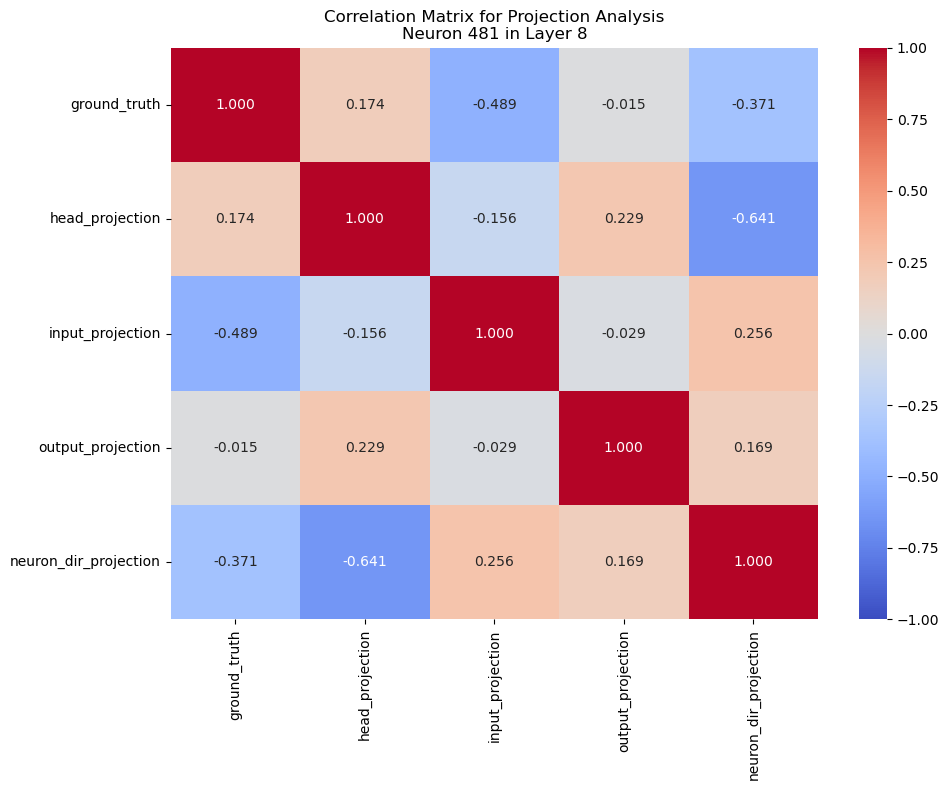

In [19]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.3f')
plt.title(f"Correlation Matrix for Projection Analysis\nNeuron {target_neuron} in Layer {target_layer}")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f"projection_correlation_matrix_l{target_layer}_n{target_neuron}.png"), dpi=300)
plt.show()

## 7. Save and Report

In [20]:
# Create a summary of findings
summary = {
    "target_layer": target_layer,
    "target_neuron": target_neuron,
    "base_model": base_model_name,
    "dataset_size": len(results_df),
    "weight_similarities": {
        "head_input": float(sim_head_input),
        "head_output": float(sim_head_output),
        "input_output": float(sim_input_output)
    },
    "projections": {
        "head": {
            "correlation": float(corr_head),
            "r_squared": float(r2_head),
            "p_value": float(p_head)
        },
        "input": {
            "correlation": float(corr_input),
            "r_squared": float(r2_input),
            "p_value": float(p_input)
        },
        "output": {
            "correlation": float(corr_output),
            "r_squared": float(r2_output),
            "p_value": float(p_output)
        },
        "neuron_dir": {
            "correlation": float(corr_neuron_dir),
            "r_squared": float(r2_neuron_dir),
            "p_value": float(p_neuron_dir)
        }
    },
    "timestamp": str(np.datetime64('now'))
}

# Save to JSON
summary_path = os.path.join(output_dir, f"projection_analysis_results_l{target_layer}_n{target_neuron}.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print(f"Results saved to {summary_path}")

Results saved to /Users/egg/Documents/ai-safety/Research Projects/neuron_self_report/code1/important-outputs/unfrozen-last-layers-learn-to-predict-30-epochs/regression-after_target-500-30epochs-neuron_l8_n481--mse29.02-20250422_1259/projection_analysis_results_l8_n481.json


In [21]:
# Display summary findings
print("Summary of Projection Analysis:\n")
print(f"Target: Neuron {target_neuron} in Layer {target_layer} of {base_model_name}")
print("\nWeight Direction Similarities:")
print(f"  Head weights & Input weights: {sim_head_input:.4f}")
print(f"  Head weights & Output weights: {sim_head_output:.4f}")
print(f"  Input weights & Output weights: {sim_input_output:.4f}")

print("\nProjection Correlations with Ground Truth:")
print(f"  Head projection: r = {corr_head:.4f}, R² = {r2_head:.4f}, p = {p_head:.4e}")
print(f"  Input projection: r = {corr_input:.4f}, R² = {r2_input:.4f}, p = {p_input:.4e}")
print(f"  Output projection: r = {corr_output:.4f}, R² = {r2_output:.4f}, p = {p_output:.4e}")
print(f"  Neuron direction projection: r = {corr_neuron_dir:.4f}, R² = {r2_neuron_dir:.4f}, p = {p_neuron_dir:.4e}")

# Determine which projection is most correlated with ground truth
correlations = [
    ("Head projection", abs(corr_head)),
    ("Input projection", abs(corr_input)),
    ("Output projection", abs(corr_output)),
    ("Neuron direction projection", abs(corr_neuron_dir))
]
best_corr = max(correlations, key=lambda x: x[1])

print(f"\nThe projection most correlated with ground truth is: {best_corr[0]} (|r| = {best_corr[1]:.4f})")

Summary of Projection Analysis:

Target: Neuron 481 in Layer 8 of gpt2

Weight Direction Similarities:
  Head weights & Input weights: 0.0453
  Head weights & Output weights: -0.0309
  Input weights & Output weights: -0.3627

Projection Correlations with Ground Truth:
  Head projection: r = 0.1736, R² = 0.0301, p = 9.5857e-05
  Input projection: r = -0.4894, R² = 0.2395, p = 0.0000e+00
  Output projection: r = -0.0147, R² = 0.0002, p = 7.4341e-01
  Neuron direction projection: r = -0.3710, R² = 0.1377, p = 0.0000e+00

The projection most correlated with ground truth is: Input projection (|r| = 0.4894)


## Interpretation

This analysis gives us insight into how different projections relate to the neuron's ground truth activation:

1. **Head Weight Projection**: This shows how well the prediction head has learned to extract the neuron's activation from the final representation. A high correlation here indicates the predictor is working well.

2. **Input Weight Projection**: This shows whether the residual stream immediately before the MLP layer already contains information about the neuron's activation, projected along its input weights. A high correlation would suggest the neuron is mostly passively reflecting existing information.

3. **Output Weight Projection**: This shows how the neuron's activation is reflected back into the residual stream after the MLP layer. A high correlation could indicate that the neuron is "writing" its information clearly into the stream.

4. **Neuron Direction Projection**: This shows if the neuron's activation persists in the final layer's representation along its initial direction. A high correlation suggests the neuron's information persists relatively unchanged throughout the network.

These relationships help us understand how information flows through the model and which representation spaces best capture the neuron's behavior.